## **[2024년 1학기 로봇공학] Ch. 4-d. 2D Forward Kinematics**

- 작성자 : 서울시립대학교 전자전기컴퓨터공학부 박경훈 교수(gyunghoon.park@uos.ac.kr)
- 작성일 : 2024. 4. 23.

In [125]:
import spatialmath as sm
import roboticstoolbox as rtb
import numpy as np
from spatialmath.base import *
from math import *
from scipy import *
%matplotlib inline

Ch. 4-d에서는 2D에서 정의된 planar manipulator들의 forward kinematics를 구하는 법에 대해 살펴봅시다.

### **Topic 1 : Introduction to Elementary Transformation**

4-a에서 소개한 대로, `Robotics Toolbox for Python`에서는 elementary transformation들의 조합을 통해 로봇을 정의할 수 있습니다.\
2D에서는 `ET2`라는 class를 이용합니다.

In [126]:
a1 = 1
e = rtb.ET2.R() * rtb.ET2.tx(a1)

위에서 2D rotation matrix `ET2.R()` 함수의 입력을 공백으로 두었기 때문에, 그에 대응되는 회전각 $q$는 자유도를 가집니다.\
`print` 함수를 이용하여 확인해봅시다.  

In [127]:
print(e)

R(q) ⊕ tx(1)


이제 forward kinematics를 계산하는 `fkine` 함수를 이용하여 $q$ 값을 지정해주면 end-effector의 위치와 자세를 설명하는 2D homogeneous transformation을 얻게 됩니다. 

In [128]:
print(e.fkine(pi/6))

   0.866    -0.5       0.866     
   0.5       0.866     0.5       
   0         0         1         



위의 2D homogeneous transformation은 ${\rm Rot}(\hat{z},\pi/6){\rm Trans}(\hat{x},a_1)$을 나타냅니다.

In [129]:
sm.SE2.Rot(pi/6) * sm.SE2.Tx(a1)

   0.866    -0.5       0.866     
   0.5       0.866     0.5       
   0         0         1         


### **Topic 2 : Forward kinematics via elementary transformation sequence**

이제 본격적으로 다수의 elementary transformation들을 조합한 ETS 형태의 로봇을 정의하고, 이에 대한 forward kinematics를 구해봅시다.\
다음과 같이 link 길이가 $a_1=1$, $a_2=1$인 2DoF planar manipulator 모델을 생성합시다.

In [130]:
a1 = 1
a2 = 1
robot = rtb.ET2.R() * rtb.ET2.tx(a1) * rtb.ET2.R() * rtb.ET2.tx(a2)

`print` 함수로 위의 `robot`을 출력하면 다음을 얻습니다. 

In [131]:
print(robot)

R(q0) ⊕ tx(1) ⊕ R(q1) ⊕ tx(1)


이제 $q_0$, $q_1$의 값을 지정하면 다음을 얻습니다.

In [132]:
robot.fkine((pi/6, pi/3))

   0        -1         0.866     
   1         0         1.5       
   0         0         1         


`robot`의 세부 정보들은 아래와 같이 얻을 수 있습니다.

In [133]:
print("DoF of `robot` :", robot.n)
print("Joint of `robot` :", robot.joints())
print("Structure of `robot` :", robot.structure)

DoF of `robot` : 2
Joint of `robot` : [ET2.R(jindex=0), ET2.R(jindex=1)]
Structure of `robot` : RR


### **Topic 2 : Chain of Robot Links**

위와 동일한 로봇에 대해 `Link2` 함수를 이용하여 tree 구조를 명확하게 지정해줄 수 있습니다.\
2D planar manipulator를 구성하는 3개의 link를 아래와 같이 정의합시다.\
(여기서 children link를 정의할 때 parent link를 명확히 지정해주는 것이 중요합니다.)

In [134]:
link1 = rtb.Link2(rtb.ET2.R(), name="link1")
link2 = rtb.Link2(rtb.ET2.tx(a1) * rtb.ET2.R(), name="link2", parent=link1)
link3 = rtb.Link2(rtb.ET2.tx(a2), name="link3", parent=link2)

이제 `ERobot2` 함수를 이용하여 위에서 정의된 `link`를 묶으면 다음과 같이 ETS 모델로 표현된 로봇을 정의할 수 있습니다.

In [135]:
robot = rtb.ERobot2([link1, link2, link3], name = "myRobot")
print(robot)

ERobot: myRobot, 2 joints (RR)
┌─────┬────────┬───────┬────────┬─────────────────────┐
│link │  link  │ joint │ parent │ ETS: parent to link │
├─────┼────────┼───────┼────────┼─────────────────────┤
│   0 │ link1  │     0 │ BASE   │ R(q0)               │
│   1 │ link2  │     1 │ link1  │ tx(1) ⊕ R(q1)       │
│   2 │ @link3 │       │ link2  │ tx(1)               │
└─────┴────────┴───────┴────────┴─────────────────────┘



이제 `fkine` 함수를 이용하여 forward kinematics를 계산합시다.

In [136]:
robot.fkine([pi/6,pi/3])

   0        -1         0.866     
   1         0         1.5       
   0         0         1         


한편 ETS 모델로 정의된 `robot`을 구성하는 link들은, `robot[idx]`의 형태로 출력할 수 있습니다.

In [137]:
print(robot[1])

Link2("link2", tx(1) ⊕ R(q), parent="link1")


또한 특정 link의 parent link와 children link도 출력할 수 있습니다.

In [138]:
print(link2.parent)
print(link2.children)

Link2("link1", R(q))
[Link2([ET2.tx(eta=1.0)], name = "link3", parent="link2")]


### **Topic 3 : Forward kinematics via product of exponentials**

Topic 3에서는 동일한 2D planar manipulator에 대하여, 주교재에서 주요하게 다루는 Product of Exponentials의 개념을 활용한 forward kinematics 계산을 수행해보겠습니다.\
이를 위해 `Twist2.UnitRevolute` 함수를 이용하여 2D screw axis $\mathcal{S}_1$과 $\mathcal{S}_2$를 아래와 같이 정의합니다.

In [139]:
S2 = sm.Twist2.UnitRevolute([a1,0])
S1 = sm.Twist2.UnitRevolute([0,0])

print('Screw axis for Joint 1 : ', S1)
print('Screw axis for Joint 2 : ', S2)

Screw axis for Joint 1 :  (-0 -0; 1)
Screw axis for Joint 2 :  (-0 -1; 1)


추가적으로 $q_1=q_2=0$일 때의 end-effector의 위치와 자세를 나타내는 2D homogeneous transformation $M$을 다음과 같이 계산합시다.

In [140]:
M = transl2(a1+a2,0)
print(M)

[[1. 0. 2.]
 [0. 1. 0.]
 [0. 0. 1.]]


이제 Product of Exponentials로 정의된 forward kinematics $$T = e^{[\mathcal{S}_1]q_1} e^{[\mathcal{S}_2]q_2} M$$ 를 함수의 형태로 정의해봅시다.

In [141]:
def fkine_PoE(q1,q2):
    a1 = 1
    a2 = 1
    S1 = sm.Twist2.UnitRevolute([0,0])
    S2 = sm.Twist2.UnitRevolute([a1,0])
    M = transl2(a1+a2,0)
    T = S1.exp(q1) * S2.exp(q2) * M
    return T

In [142]:
print(fkine_PoE(pi/6,pi/3))

[[ 2.14607521e-16 -1.00000000e+00  8.66025404e-01]
 [ 1.00000000e+00  2.07170437e-16  1.50000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


이제 위의 과정을 `trplot2`를 이용하여 그려봅시다.

<Axes: xlabel='X', ylabel='Y'>

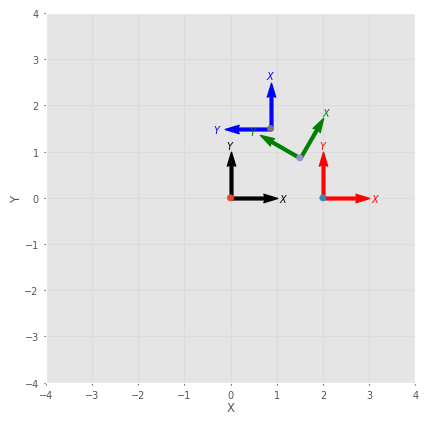

In [144]:
plotvol2([-4, 4])
trplot2(transl2([0,0]), color = "black")
trplot2(M, color = "red")
trplot2(S2.SE2(pi/3) * M, color = "green")
trplot2(fkine_PoE(pi/6,pi/3))